# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 11)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2024


In [5]:
if year is None:
    year = cur_year

pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2024-PATH-Monthly-Ridership-Report.pdf'

In [6]:
if last_month is None:
    if year == cur_year:
        from PyPDF2 import PdfReader

        reader = PdfReader(pdf)
        num_pages = len(reader.pages)
        last_month = num_pages - 1
        err(f"Inferred {last_month=}")
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

Inferred last_month=9


In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'page': 1,
  'extraction_method': 'guess',
  'x1': 54.315,
  'x2': 577.575,
  'y1': 116.00001000000002,
  'y2': 238.40001,
  'width': 523.26,
  'height': 122.4},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 253.000035,
  'y2': 401.41003500000005,
  'width': 519.4350000000001,
  'height': 148.41},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 474.999975,
  'y2': 592.809975,
  'width': 519.4350000000001,
  'height': 117.81},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 56.61,
  'x2': 578.34,
  'y1': 611.000145,
  'y2': 753.290145,
  'width': 521.73,
  'height': 142.29}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[116.00001000000002, 54.315, 238.40001, 577.575],
 [253.000035, 58.14, 401.41003500000005, 577.575],
 [474.999975, 58.14, 592.809975, 577.575],
 [611.000145, 56.61, 753.290145, 578.34]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.
No module named 'jpype'


{1: [                    0          1       2       3       4       5
  0  Christopher Street     86,831   3,147   2,511   1,784   1,784
  1          9th Street     75,977   2,792   2,108   1,401   1,651
  2         14th Street    127,321   4,834   3,037   2,180   2,472
  3         23rd Street    122,336   5,033   1,964   1,287   1,817
  4         33rd Street    500,254  19,543   9,702   6,865  11,787
  5     UPTOWN SUBTOTAL    912,719  35,350  19,322  13,517  19,510
  6                 WTC    922,430  37,278  15,316  11,296  16,569
  7   NEW YORK SUBTOTAL  1,835,149  72,628  34,638  24,813  36,079,
                       0          1        2       3       4       5
  0               Newark    344,156   14,267   5,102   3,413   5,244
  1             Harrison    130,445    5,417   2,086   1,154   1,862
  2       Journal Square    474,171   18,174  10,822   7,634   9,348
  3         Grove Street    366,378   14,545   7,620   4,638   5,955
  4       Exchange Place    248,376   10,112   4

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables


9

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"86,831","3,147","2,511","1,784","1,784",2024-01-01
1,9th Street,"75,977","2,792","2,108","1,401","1,651",2024-01-01
2,14th Street,"127,321","4,834","3,037","2,180","2,472",2024-01-01
3,23rd Street,"122,336","5,033","1,964","1,287","1,817",2024-01-01
4,33rd Street,"500,254","19,543","9,702","6,865","11,787",2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"309,896","12,610","6,663","5,105","5,517",2024-09-01
5,Newport,"321,178","13,281","6,839","4,735","4,520",2024-09-01
6,Hoboken,"469,524","18,984","11,439","7,553","6,321",2024-09-01
7,NEW JERSEY SUBTOTAL,"2,805,223","113,320","65,217","46,669","44,606",2024-09-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,86831,3147,2511,1784,1784,2024-01-01
1,9th Street,75977,2792,2108,1401,1651,2024-01-01
2,14th Street,127321,4834,3037,2180,2472,2024-01-01
3,23rd Street,122336,5033,1964,1287,1817,2024-01-01
4,33rd Street,500254,19543,9702,6865,11787,2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,309896,12610,6663,5105,5517,2024-09-01
5,Newport,321178,13281,6839,4735,4520,2024-09-01
6,Hoboken,469524,18984,11439,7553,6321,2024-09-01
7,NEW JERSEY SUBTOTAL,2805223,113320,65217,46669,44606,2024-09-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,2801,66085,10043,7136,3567,2024-01-01
1,9th Street,2451,58641,8433,5602,3301,2024-01-01
2,14th Street,4107,101507,12149,8721,4944,2024-01-01
3,23rd Street,3946,105700,7855,5147,3634,2024-01-01
4,33rd Street,16137,410413,38806,27461,23574,2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,10330,252203,26653,25523,5517,2024-09-01
5,Newport,10706,265628,27357,23673,4520,2024-09-01
6,Hoboken,15651,379682,45754,37767,6321,2024-09-01
7,NEW JERSEY SUBTOTAL,93507,2266403,260867,233347,44606,2024-09-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2024-01-01 Christopher Street        2801         3147     2511     1784   
           9th Street                2451         2792     2108     1401   
           14th Street               4107         4834     3037     2180   
           23rd Street               3946         5033     1964     1287   
           33rd Street              16137        19543     9702     6865   
...                                   ...          ...      ...      ...   
2024-09-01 Exchange Place           10330        12610     6663     5105   
           Newport                  10706        13281     6839     4735   
           Hoboken                  15651        18984    11439     7553   
           NEW JERSEY SUBTOTAL      93507       113320    65217    46669   
           MONTHLY TOTAL           170701       206543   117930    87805   

                                avg holiday    total  total weekday  \
month      station                                                    
2024-01-01 Christopher Street          1784    86831          66085   
           9th Street                  1651    75977          58641   
           14th Street                 2472   127321         101507   
           23rd Street                 1817   122336         105700   
           33rd Street                11787   500254         410413   
...                                     ...      ...            ...   
2024-09-01 Exchange Place              5517   309896         252203   
           Newport                     4520   321178         265628   
           Hoboken                     6321   469524         379682   
           NEW JERSEY SUBTOTAL        44606  2805223        2266403   
           MONTHLY TOTAL              79429  5121025        4130852   

                                total sat  total sun  total holiday  
month      station                                                   
2024-01-01 Christopher Street       10043       7136           3567  
           9th Street                8433       5602           3301  
           14th Street              12149       8721           4944  
           23rd Street               7855       5147           3634  
           33rd Street              38806      27461          23574  
...                                   ...        ...            ...  
2024-09-01 Exchange Place           26653      25523           5517  
           Newport                  27357      23673           4520  
           Hoboken                  45754      37767           6321  
           NEW JERSEY SUBTOTAL     260867     233347          44606  
           MONTHLY TOTAL           471721     439023          79429  

[153 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

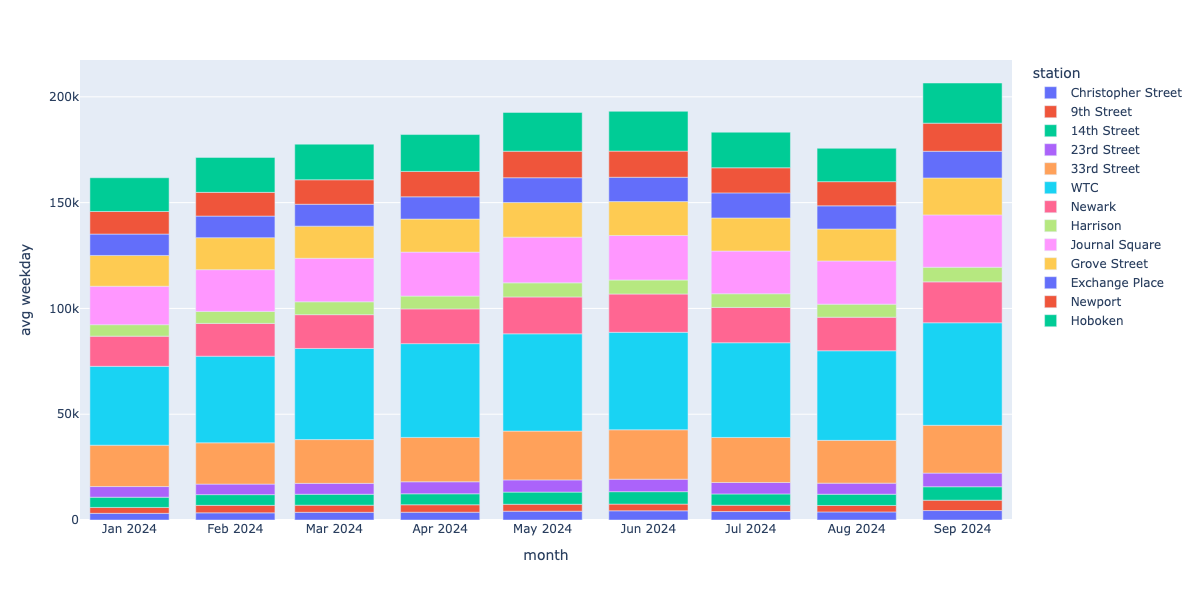

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))